In [182]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

# Previously trained VGG16

In [209]:
# Parameters for experimenting.
model_dir = "../results/classification/20201221_064530_INSTANCE/saved_model/20201221_064530"
layer_name = "block5_conv3"

# img_path = "/Users/cleonwong/Desktop/Code/mammogram-cv/data/preprocessed/Classification/all_classification_CROP/Calc-Test_P_01030_RIGHT_CC_CROP_1___PRE.png"
# img_path = "/Users/cleonwong/Desktop/Code/mammogram-cv/data/preprocessed/Classification/all_classification_CROP/Calc-Test_P_01030_RIGHT_CC_CROP_2___PRE.png"
# img_path = "/Users/cleonwong/Desktop/Code/mammogram-cv/data/preprocessed/Classification/all_classification_CROP/Mass-Training_P_00265_RIGHT_CC_CROP_1___PRE.png"
# img_path = "/Users/cleonwong/Desktop/Code/mammogram-cv/data/preprocessed/Classification/all_classification_CROP/Mass-Training_P_00921_RIGHT_CC_CROP_1___PRE.png"
img_path = "/Users/cleonwong/Desktop/Code/mammogram-cv/data/preprocessed/Classification/all_classification_CROP/Mass-Training_P_01749_LEFT_MLO_CROP_1___PRE.png"
dsize = (224, 224)

# Load sample image for experimenting.
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(src=img, dsize=dsize)

# Min max normalise to [0, 1].
img = (img - img.min()) / (img.max() - img.min())

# Stack grayscale image to make channels=3.
img = np.stack([img, img, img], axis=-1)

# Make img shape into (1, 224, 224, 3).
img = img[np.newaxis, :]

In [193]:
# Load previously trained model.
model = tf.keras.models.load_model(filepath=model_dir)

# Perform Grad-CAM 

In [210]:
# Get the target convolution layer.
conv_layer = model.get_layer(layer_name)

# Then create a model that goes up to only that `conv_layer` layer.
grad_model = tf.keras.models.Model(
    inputs=model.inputs, outputs=[conv_layer.output, model.outputs], name="grad_model"
)

# Get the score (y_c) for the target class.
with tf.GradientTape() as tape:
    
    # `conv_outputs` is the outputed feature maps from the final conv layer.
    # `predictions` is the computed loss value
    last_conv_outputs, predictions = grad_model(img) # To make the shape (1, 224, 224, 3)
    y_c = predictions[0][0]


# Step 1:
# Calculate the partial derivative of the model outputs (y_c) wrt the feature map activations of `conv_layer`.
# Each one of these gradients represents the connection from one of the pixels in the feature maps to the output neuron representing the target class.
gradients = tape.gradient(y_c, last_conv_outputs)[0]

# Step 2:
# Do global average pooling on the gradients to get the alphas.
pooled_gradients = tf.reduce_mean(gradients, axis=[0, 1])

# Step 3:
# Do element-wise multiplication between each feature map and its corresponding alpha. 
last_conv_outputs = last_conv_outputs.numpy()[0]
pooled_gradients = pooled_gradients.numpy()

# Element-wise multiplication.
for i in range(pooled_gradients.shape[-1]):
    last_conv_outputs[:, :, i] *= pooled_gradients[i]

# Sum all feature maps to get a single 2D array.
gradcam = np.sum(last_conv_outputs, axis=-1)

# Apply RELU (i.e. max(0, element)).
gradcam = np.clip(a=gradcam, a_min=0, a_max=gradcam.max())

# Min-max normalise.
gradcam = (gradcam - gradcam.min()) / (gradcam.max() - gradcam.min())

# Resize to (224, 224).
gradcam = cv2.resize(src=gradcam, dsize=(224, 224))

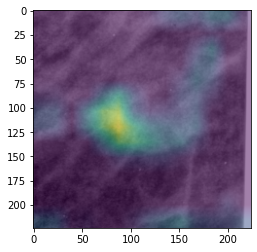

In [211]:
plt.imshow(img[0])
plt.imshow(gradcam, alpha=0.5)

In [213]:
x = model.predict(x=img)

In [217]:
x[0][0]

0.4364951

# ResNet50

In [39]:
model = tf.keras.applications.ResNet50()

In [100]:
last_conv_layer = model.get_layer("conv5_block3_out")
# last_conv_layer_model = tf.keras.Model(inputs=model.inputs, outputs=last_conv_layer.output, name="last_conv_layer_model")
last_conv_layer_model = tf.keras.Model(inputs=model.inputs, outputs=[last_conv_layer.output, model.outputs], name="last_conv_layer_model")

In [79]:
last_conv_layer_model.summary()

Model: "last_conv_layer_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________

In [94]:
classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in ["avg_pool", "predictions"]:
    x = model.get_layer(layer_name)(x)
classifier_model = tf.keras.Model(classifier_input, x)

In [95]:
classifier_model.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 7, 7, 2048)]      0         
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 2048)              0         
_________________________________________________________________
predictions (Dense)          (None, 1000)              2049000   
Total params: 2,049,000
Trainable params: 2,049,000
Non-trainable params: 0
_________________________________________________________________


In [96]:
with tf.GradientTape() as tape:
    
    # This is the feature maps outputted from the last conv layer.
    last_conv_layer_output = last_conv_layer_model(img)
    
    tape.watch(last_conv_layer_output)
    
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

In [98]:
type(top_class_channel)

tensorflow.python.framework.ops.EagerTensor

In [77]:
preds

<tf.Tensor: shape=(1, 1000), dtype=float32, numpy=
array([[1.58154013e-04, 2.85063143e-04, 5.35043910e-05, 1.01202291e-04,
        4.71173735e-05, 4.80410701e-04, 7.18960973e-06, 3.20134677e-05,
        1.43464076e-05, 1.30170127e-04, 7.09355285e-04, 1.26733808e-04,
        5.29228455e-05, 7.32210538e-05, 1.38152254e-05, 4.15840695e-05,
        1.19814729e-04, 2.50429221e-05, 5.07941804e-05, 4.45476799e-05,
        1.78924907e-04, 1.63370941e-03, 9.22117615e-04, 2.06624522e-04,
        7.68825630e-05, 9.86395098e-05, 3.14631499e-04, 2.18853937e-04,
        1.60527256e-04, 1.90184044e-04, 3.61528546e-05, 2.85198563e-04,
        7.85549055e-05, 1.04657855e-04, 2.50319164e-04, 1.37218140e-05,
        1.17712865e-04, 9.23274183e-06, 5.70148556e-03, 3.20865802e-05,
        4.05358696e-05, 1.93951739e-04, 2.39973175e-04, 1.69293911e-04,
        4.99025955e-05, 1.15310439e-04, 3.51427516e-05, 2.23891941e-04,
        3.40038823e-05, 3.44135697e-05, 1.54360925e-04, 4.07839776e-04,
        2.684

In [119]:
with tf.GradientTape() as tape:

    # This is the feature maps outputted from the last conv layer.
    last_conv_layer_output, predictions = last_conv_layer_model(img)
    
    tape.watch(last_conv_layer_output)
    
    top_pred_index = tf.argmax(predictions[0][0])
    top_class_channel = predictions[0][:, top_pred_index]

In [121]:
type(top_class_channel)

tensorflow.python.framework.ops.EagerTensor

In [64]:
predictions[0]

[<tf.Tensor: shape=(1, 1000), dtype=float32, numpy=
 array([[1.58154013e-04, 2.85063143e-04, 5.35043910e-05, 1.01202291e-04,
         4.71173735e-05, 4.80410701e-04, 7.18960973e-06, 3.20134677e-05,
         1.43464076e-05, 1.30170127e-04, 7.09355285e-04, 1.26733808e-04,
         5.29228455e-05, 7.32210538e-05, 1.38152254e-05, 4.15840695e-05,
         1.19814729e-04, 2.50429221e-05, 5.07941804e-05, 4.45476799e-05,
         1.78924907e-04, 1.63370941e-03, 9.22117615e-04, 2.06624522e-04,
         7.68825630e-05, 9.86395098e-05, 3.14631499e-04, 2.18853937e-04,
         1.60527256e-04, 1.90184044e-04, 3.61528546e-05, 2.85198563e-04,
         7.85549055e-05, 1.04657855e-04, 2.50319164e-04, 1.37218140e-05,
         1.17712865e-04, 9.23274183e-06, 5.70148556e-03, 3.20865802e-05,
         4.05358696e-05, 1.93951739e-04, 2.39973175e-04, 1.69293911e-04,
         4.99025955e-05, 1.15310439e-04, 3.51427516e-05, 2.23891941e-04,
         3.40038823e-05, 3.44135697e-05, 1.54360925e-04, 4.07839776e-04,